# Introduction to Large Language Models

(Pytorch nanoGPT code is from: https://github.com/karpathy/nanoGPT/blob/master/model.py)

## Intro

This chapter serves as an introduction to the basic concepts in Large Language Model (LLM) architectures and training. In the first section we will introduce the basic blocks and mechanisms of the transformer architecture, which most modern LLMs are based on. Next, we will introduce the basic ideas involved in the training of the LLMs. In addition, this notebook is intended to provide a runnable code implementation of the nanoGPT model and a basic training pipeline.


## Transformer Architecture

Most modern LLMs are based on the *decoder-only transformer* model architecture. Essentially, the decoder-only transformer (we will refer to it simply as transformer) is a deep learning model built from multiple *transformer layers* as well as an *embedding* and a *Language Model (LM) Head* layer in the input and output, respectively.

The transformer model takes as input sequences of *tokens* and outputs a probability distribution over possible next tokens for each input position. Those probability distributions are then used to generate the output text of the model.

Next we will describe in detail its components and provide the corresponding codes.

In [1]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass
import inspect
import numpy as np
from typing import Callable, Iterable, Tuple

### Tokenizer

Neural Networks such as the transformer work with numbers, not text. Therefore the input texts need to be converted to sequences of numbers before the transformer can process them. Thus, the text is first converted into discrete components known as *tokens*, which constitute the model's vocabulary $V$. Each of the tokens corresponds to a unique number, the *token ID*.

The module that performs the conversion is called the *tokenizer*. It is technically considered a preprocessing module, separate from the transformer architecture. There are a number of different approaches to tokenization with one of the most popular being *Byte Pair Encoding (BPE)*, which performs subword tokenization by iteratively merging the most frequent pairs of symbols in the text. An important parameter of the tokenizer is the vocabulary size $V$, which is the total number of unique tokens it can produce and the model can recognize.  

In short, the tokenizer, given as input raw text sequences, outputs a batch of token sequences and their corresponding IDs, which normally have a shape $[B, L]$. Here $B$ is the *batch size* that determines the number of sequences (or samples) the transformer will process in parallel and $L$ is the number of tokens per sequence.

The batch of token ID sequences will then be converted to a batch of *embeddings vectors* (one embedding per token) by the *embedding layer* of the transformer.

In [2]:
from transformers import AutoTokenizer

# Load the GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

print("Pad token/ID:", tokenizer.pad_token,  tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
print("Vocabulary size |V|:", tokenizer.vocab_size)

# Example batch of texts
texts = [
    "The cat sat on the mat",
    "A quick brown fox jumps over the lazy dog!"
]

# Tokenize the batch with padding, L=10
encoded = tokenizer(texts, return_tensors="pt", max_length=10 , truncation=True,  padding="max_length" )

tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in encoded["input_ids"]]
print("Tokens:", *tokens, sep="\n")
print("Input IDs:\n", encoded["input_ids"])
print("Attention Mask:\n", encoded["attention_mask"])

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Pad token/ID: <|endoftext|> 50256
Vocabulary size |V|: 50257
Tokens:
['The', 'Ġcat', 'Ġsat', 'Ġon', 'Ġthe', 'Ġmat', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']
['A', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġlazy', 'Ġdog', '!']
Input IDs:
 tensor([[  464,  3797,  3332,   319,   262,  2603, 50256, 50256, 50256, 50256],
        [   32,  2068,  7586, 21831, 18045,   625,   262, 16931,  3290,     0]])
Attention Mask:
 tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


Note that Ġ is a special symbol that the particular tokenizer usees to represent a space before a word.

### Embedding Layer

The input tokens are discrete and therefore not directly optimizable by gradient-based methods. Thus they need to be converted to continuous, dense vectors that capture semantic meanings and can be learned and optimized by the transformer. This is done by the *embedding layer*.

The embedding layer is essentially a trainable look-up table. It takes as input the token IDs and outputs the corresponding rows - which are the *embedding vectors* for the specified token IDs. It has shape ($|V|$, $d_{\text{model}}$), where $d_{\text{model}}$ is the dimension of the embedding vectors. Bellow is an example of how it looks in code:


```python
embedding.weight = [
    [e1_1, e1_2, ..., e1_d],   # embedding for token 1
    [e2_1, e2_2, ..., e2_d],   # embedding for token 2
    ...
    [en_1, en_2, ..., en_d],   # embedding for token n
]
# where n = |V| and d = d_model
```

Therefore, the embedding layer for an input tensor of shape $[B, L]$ it will output a tensor of shape $[B, L, d_{\text{model}}]$.


In [3]:
V = tokenizer.vocab_size #|V| = 50256
d_model = 3 # Small value for illustration purposes. E.g., nanoGPT uses d_model=768

embedding = nn.Embedding(num_embeddings=V, embedding_dim=d_model)

# Token IDs from previous example.
input_ids = encoded["input_ids"]

print("Token IDs:\n", input_ids)

embedded_vectors = embedding(input_ids)

print("Embedding vectors:\n", embedded_vectors)
print("Embedding Layer output shape:", embedded_vectors.shape) # Output shape [B=2, L=10, d_model=3]

Token IDs:
 tensor([[  464,  3797,  3332,   319,   262,  2603, 50256, 50256, 50256, 50256],
        [   32,  2068,  7586, 21831, 18045,   625,   262, 16931,  3290,     0]])
Embedding vectors:
 tensor([[[ 0.1296,  0.4145,  0.3291],
         [ 0.4642,  0.6529,  1.5106],
         [ 0.6541, -1.6905, -0.0428],
         [ 3.4913,  0.0044,  2.0248],
         [-0.5078,  0.0327,  1.3537],
         [ 1.4801, -0.6434, -0.6449],
         [ 0.0767, -0.6003, -1.3610],
         [ 0.0767, -0.6003, -1.3610],
         [ 0.0767, -0.6003, -1.3610],
         [ 0.0767, -0.6003, -1.3610]],

        [[-0.2072,  0.5900,  0.3016],
         [-0.9791, -0.9526, -0.3668],
         [-0.2680, -0.7087, -1.1556],
         [-0.1547,  1.1106, -0.5717],
         [ 1.1608, -0.0681,  2.5914],
         [ 0.8884,  0.2063, -0.2748],
         [-0.5078,  0.0327,  1.3537],
         [-1.8141, -0.3699, -0.7468],
         [-1.4542,  2.2813,  1.2167],
         [-0.5531,  1.1152,  0.3273]]], grad_fn=<EmbeddingBackward0>)
Embedding Lay

### Self-attention

Self-attention is a mechanism that transforms the representation of each token in a sequence by relating it to different tokens of the sequence. This new representation can then be used by the model to e.g., predict the next word of the sequence.

For example, lets say we have the sentence "The cat sat on the mat". We can assume a simple word tokenizer and an embedding layer which results in one embedding vector for each word:  

<div align="center">

| The    | cat   | sat   | on    | the   | mat   |
|-------|-------|-------|-------|-------|-------|
| $e_1$ | $e_2$ | $e_3$ | $e_4$ | $e_5$ | $e_6$ |

</div>

If we wanted to create a model to predict the next word, we could directly just use an MLP+softmax (see bellow for more details about softmax) with input one of the embedding vectors like the above and output a probability distribution over the vocabulary.

$$
\begin{array}{c}
\text{Input Tokens} \quad [B, L] \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Embedding Layer}
\end{array}
} \\
\downarrow \\
\text{Token Embeddings} \quad [B, L, d_{\text{model}}] \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{MLP (Feed-Forward Network)}
\end{array}
} \\
\downarrow \\
\text{MLP Output} \quad [B, L, |V|] \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Softmax (next token probabilities)}
\end{array}
} \\
\downarrow \\
\text{Output Probabilities} \quad [B, L, |V|]
\end{array}
$$


However, currently each embedding $e_i$ contains information only for the particular word it embeds, regardless of the rest of the sequence. So for example given $e_5$ the model would just predict the most probable word after a "the", which is certainly not "mat". Instead, with a self-attention layer $e_5$ will be transformed into $e_5' = f(e_1, e_2, e_3, e_4, e_5)$, now containing the context. Here $f()$ represents the self-attention transformation that produces the *contextualized* embedding, which we will describe in details in the next part.

**More on the Softmax Operator** Given a vector of logits $\mathbf{z} = [z_1, z_2, \dots, z_{|V|}] \in \mathbb{R}^{|V|} $, where $|V| $ is the vocabulary size, the softmax function is defined component-wise as:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{|V|} e^{z_j}}, \quad \text{for } i = 1, \dots, |V|.
$$

The output is a probability vector  $\mathbf{p} = \text{softmax}(\mathbf{z}) \in \mathbb{R}^{|V|} $ such that:

- $ p_i > 0 $ for all $ i $
- $ \sum_{i=1}^{|V|} p_i = 1 $

Thus, $\mathbf{p} \in \Delta^{|V|-1} $, the probability simplex.

Bellow we will describe how self-attention is computed.


### Scaled Dot-Product Attention

- Assume batch size B=1
- X is the embedding matrix (contains the embedding vectors of $L$ tokens)
- Assume single attention layer after the embedding layer

Input matrix:

$$
X =
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_L
\end{bmatrix}
\in \mathbb{R}^{L \times d_{\text{model}}}
$$



We apply learned projection matrices:

$$
W_Q \in \mathbb{R}^{d_{\text{model}} \times d_q}, \quad
W_K \in \mathbb{R}^{d_{\text{model}} \times d_k}, \quad
W_V \in \mathbb{R}^{d_{\text{model}} \times d_v}
$$

To obtain the queries, keys, and values:


                    
$$
Q = X W_Q =
\begin{bmatrix}
q_1 \\
q_2 \\
\vdots \\
q_L
\end{bmatrix}
\in \mathbb{R}^{L \times d_q}, \quad
K = X W_K =
\begin{bmatrix}
k_1 \\
k_2 \\
\vdots \\
k_L
\end{bmatrix}
\in \mathbb{R}^{L \times d_k}, \quad
V = X W_V =
\begin{bmatrix}
v_1 \\
v_2 \\
\vdots \\
v_L
\end{bmatrix}
\in \mathbb{R}^{L \times d_v}
$$

Attention logits matrix $QK^T$:

$$
QK^T \in \mathbb{R}^{L \times L} =
\begin{bmatrix}
q_1 \\
q_2 \\
\vdots \\
q_L
\end{bmatrix}
\cdot
\begin{bmatrix}
k_1^T & k_2^T & \cdots & k_L^T
\end{bmatrix}
=
\begin{bmatrix}
q_1 k_1^T & q_1 k_2^T & \cdots & q_1 k_L^T \\
q_2 k_1^T & q_2 k_2^T & \cdots & q_2 k_L^T \\
\vdots & \vdots & \ddots & \vdots \\
q_L k_1^T & q_L k_2^T & \cdots & q_L k_L^T \\
\end{bmatrix}
$$


Attention weight matrix $A$:


$$
A = [a_{ij}] \in \mathbb{R}^{L \times L} =
\textrm{Softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) =
\begin{bmatrix}
\frac{\exp \left( \frac{q_1 k_1^T}{\sqrt{d_k}} \right)}{\sum\limits_{j=1}^{L} \exp \left( \frac{q_1 k_j^T}{\sqrt{d_k}} \right)} & \cdots & \frac{\exp \left( \frac{q_1 k_L^T}{\sqrt{d_k}} \right)}{\sum\limits_{j=1}^{L} \exp \left( \frac{q_1 k_j^T}{\sqrt{d_k}} \right)} \\
\vdots & \ddots & \vdots \\
\frac{\exp \left( \frac{q_L k_1^T}{\sqrt{d_k}} \right)}{\sum\limits_{j=1}^{L} \exp \left( \frac{q_L k_j^T}{\sqrt{d_k}} \right)} & \cdots & \frac{\exp \left( \frac{q_L k_L^T}{\sqrt{d_k}} \right)}{\sum\limits_{j=1}^{L} \exp \left( \frac{q_L k_j^T}{\sqrt{d_k}} \right)}
\end{bmatrix}
$$

Note that $a_{ij}$ is the attention weight of query $q_i$ wrt key $k_j$ and indicates the level of attention that token $i$ pays on token $j$.

Attention output $Z$:


$$
Z \in \mathbb{R}^{L \times d_v} =
\textrm{Softmax} \left( \frac{Q K^T}{\sqrt{d_k}} \right) \cdot V
=
\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1L} \\
a_{21} & a_{22} & \cdots & a_{2L} \\
\vdots & \vdots & \ddots & \vdots \\
a_{L1} & a_{L2} & \cdots & a_{LL}
\end{bmatrix}
\cdot
\begin{bmatrix}
v_1 \\
v_2 \\
\vdots \\
v_L
\end{bmatrix}
=
\begin{bmatrix}
\sum\limits_{j=1}^{L} a_{1j} v_j \\
\sum\limits_{j=1}^{L} a_{2j} v_j \\
\vdots \\
\sum\limits_{j=1}^{L} a_{Lj} v_j
\end{bmatrix}
$$


$Z$ is the output of the attention layer, which weights the value vectors $v_i$ based on the computed attention weights. Each $z_i$ combines information from different value vectors (corresponding to different tokens) according to the attention given to each key by each query.



In [4]:
# Numpy implementation of dot-product attention:

# Define embedding vectors for tokens (3 tokens/sq_len, 4-dimensional embeddings)
embedding_dim = 4
X = np.array([[0.1, 0.2, 0.3, 0.4],   # Embedding for token 1
              [0.5, 0.6, 0.7, 0.8],   # Embedding for token 2
              [0.9, 1.0, 1.1, 1.2]])  # Embedding for token 3

# Define weight matrices for the transformations (W_Q, W_K, W_V)
W_Q = np.random.rand(embedding_dim, embedding_dim)  # Query weight matrix
W_K = np.random.rand(embedding_dim, embedding_dim)  # Key weight matrix
W_V = np.random.rand(embedding_dim, embedding_dim)  # Value weight matrix

# Compute the Q, K, V matrices by applying the transformations to the embeddings
Q = np.dot(X, W_Q)  # Query matrix (Q)
K = np.dot(X, W_K)  # Key matrix (K)
V = np.dot(X, W_V)  # Value matrix (V)

# Define the scaling factor (sqrt of key dimension)
d_k = K.shape[1]
scaling_factor = np.sqrt(d_k)

# Compute the attention logits (Q K^T / sqrt(d_k))
logits = np.dot(Q, K.T) / scaling_factor

# Apply softmax to the logits to get attention weights
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

attention_weights = softmax(logits)

# Compute the output Z (weighted sum of values)
Z = np.dot(attention_weights, V)

print("Embeddings:\n", X)
print("\nQuery Matrix (Q):\n", Q)
print("\nKey Matrix (K):\n", K)
print("\nValue Matrix (V):\n", V)
print("\nAttention Logits (Q K^T / sqrt(d_k)):\n", logits)
print("\nAttention Weights (Softmax of Logits):\n", attention_weights)
print("\nOutput Z (Weighted Sum of Values):\n", Z)

Embeddings:
 [[0.1 0.2 0.3 0.4]
 [0.5 0.6 0.7 0.8]
 [0.9 1.  1.1 1.2]]

Query Matrix (Q):
 [[0.61813107 0.45006872 0.50178942 0.37187442]
 [1.52446772 1.30629011 1.3495264  1.08329982]
 [2.43080437 2.1625115  2.19726338 1.79472521]]

Key Matrix (K):
 [[0.49155078 0.63600866 0.40817395 0.53884428]
 [1.221927   1.77719537 0.94109091 1.37209303]
 [1.95230322 2.91838209 1.47400787 2.20534178]]

Value Matrix (V):
 [[0.25310593 0.51028359 0.16528225 0.47660737]
 [0.69089158 1.2593438  0.57305515 1.18998258]
 [1.12867724 2.00840401 0.98082805 1.90335778]]

Attention Logits (Q K^T / sqrt(d_k)):
 [[0.49764509 1.26882343 2.04000176]
 [1.35736828 3.47036808 5.58336789]
 [2.21709146 5.67191274 9.12673401]]

Attention Weights (Softmax of Logits):
 [[1.27585052e-01 2.75878775e-01 5.96536173e-01]
 [1.28673786e-02 1.06452100e-01 8.80680521e-01]
 [9.66611603e-04 3.05958005e-02 9.68437588e-01]]

Output Z (Weighted Sum of Values):
 [[0.89619166 1.61061643 0.76428071 1.52452068]
 [1.07080773 1.90938809 0.

### Masked (or causal) self-attention

In practice, transformers use a version of self-attention called masked or causal self-attention. In contrast to (bidirectional) self-attention that computes attentions scores for all tokens in the sequence, masked self-attention uses a *causal mask* that hides future tokens, so each token can attend to itself and earlier tokens.

Example of a casual mask:

$$
\begin{array}{c|cccccc}
    & \text{The} & \text{cat} & \text{sat} & \text{on} & \text{the} & \text{mat} \\
\hline
\text{The} & 1 & 0 & 0 & 0 & 0 & 0 \\
\text{cat} & 1 & 1 & 0 & 0 & 0 & 0 \\
\text{sat} & 1 & 1 & 1 & 0 & 0 & 0 \\
\text{on}  & 1 & 1 & 1 & 1 & 0 & 0 \\
\text{the} & 1 & 1 & 1 & 1 & 1 & 0 \\
\text{mat}& 1 & 1 & 1 & 1 & 1 & 1
\end{array}
$$

Where 1 means the token can attend, 0 means it’s masked out. Note that for simplicity each word represents a token. So,
- "The" can attend only to itself.
- "cat" can attend only to "The" and "cat".
- "mat" can attend to everything in this sentence.

Usually this masking is done by setting the $q_i k_j^T$ with $i < j$ to $-\infty$ in the $QK^T$ attention logits matrix so that the application of the softmax will give zero attention weights to those positions.

In short, using the same notation as scaled-dot product attention where $X$ is the input embedding matrix, masked self attention computes:

$$
Z_\text{masked}  \in  \mathbb{R}^{L \times d_v}
=
\text{Softmax}\!\left(
\frac{QK^{T}}{\sqrt{d_k}} + \log M
\right)V,
\quad Q=XW_Q,\, K=XW_K,\, V=XW_V.
$$

where

$$
(\log M)_{ij} =
\begin{cases}
0, & j \le i, \\[4pt]
-\infty, & j > i.
\end{cases}
$$

Note that $i$ here corresponds to a row (query token index) and $j$ to a column (key token index) of $QK^{T}$.

In [5]:
# Numpy implementation of masked self-attention:

# Define embedding vectors for tokens (3 tokens/sq_len, 4-dimensional embeddings)
embedding_dim = 4
X = np.array([[0.1, 0.2, 0.3, 0.4],   # Embedding for token 1
              [0.5, 0.6, 0.7, 0.8],   # Embedding for token 2
              [0.9, 1.0, 1.1, 1.2]])  # Embedding for token 3

# Define weight matrices for the transformations (W_Q, W_K, W_V)
W_Q = np.random.rand(embedding_dim, embedding_dim)  # Query weight matrix
W_K = np.random.rand(embedding_dim, embedding_dim)  # Key weight matrix
W_V = np.random.rand(embedding_dim, embedding_dim)  # Value weight matrix

# Compute the Q, K, V matrices by applying the transformations to the embeddings
Q = np.dot(X, W_Q)  # Query matrix (Q)
K = np.dot(X, W_K)  # Key matrix (K)
V = np.dot(X, W_V)  # Value matrix (V)

# Define the scaling factor (sqrt of key dimension)
d_k = K.shape[1]
scaling_factor = np.sqrt(d_k)

# Compute the attention logits (Q K^T / sqrt(d_k))
logits = np.dot(Q, K.T) / scaling_factor

# Create causal mask: shape (seq_len, seq_len)
seq_len = X.shape[0]
mask = np.tril(np.ones((seq_len, seq_len)))  # Lower triangular matrix including diagonal

# Apply mask: set logits where mask==0 to very large negative value (simulate -inf)
logits_masked = np.where(mask == 1, logits, -1e9)

# Apply softmax to the masked logits to get attention weights
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
    return e_x / np.sum(e_x, axis=1, keepdims=True)

attention_weights = softmax(logits_masked)

# Compute the output Z (weighted sum of values)
Z = np.dot(attention_weights, V)

print("Embeddings:\n", X)
print("\nQuery Matrix (Q):\n", Q)
print("\nKey Matrix (K):\n", K)
print("\nValue Matrix (V):\n", V)
print("\nAttention Logits (Q K^T / sqrt(d_k)):\n", logits)
print("\nMask (1=keep, 0=mask):\n", mask)
print("\nMasked Attention Logits:\n", logits_masked)
print("\nAttention Weights (Softmax of Masked Logits):\n", attention_weights)
print("\nOutput Z (Weighted Sum of Values):\n", Z)

Embeddings:
 [[0.1 0.2 0.3 0.4]
 [0.5 0.6 0.7 0.8]
 [0.9 1.  1.1 1.2]]

Query Matrix (Q):
 [[0.77259122 0.58839732 0.59604137 0.55662128]
 [1.83517005 1.54039332 1.4282729  1.51596075]
 [2.89774888 2.49238932 2.26050442 2.47530022]]

Key Matrix (K):
 [[0.49995455 0.38351055 0.70871359 0.4799025 ]
 [1.26993696 1.05149935 1.71628577 1.43159499]
 [2.03991936 1.71948815 2.72385795 2.38328749]]

Value Matrix (V):
 [[0.51639347 0.5124138  0.45281154 0.42587846]
 [1.47375801 1.28631167 1.02240151 1.10464183]
 [2.43112254 2.06020954 1.59199147 1.7834052 ]]

Attention Logits (Q K^T / sqrt(d_k)):
 [[ 0.65073182  1.70983755  2.76894328]
 [ 1.62400423  4.28591955  6.94783487]
 [ 2.59727664  6.86200155 11.12672646]]

Mask (1=keep, 0=mask):
 [[1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]

Masked Attention Logits:
 [[ 6.50731817e-01 -1.00000000e+09 -1.00000000e+09]
 [ 1.62400423e+00  4.28591955e+00 -1.00000000e+09]
 [ 2.59727664e+00  6.86200155e+00  1.11267265e+01]]

Attention Weights (Softmax of Masked Logits

### Multi-Head Attention:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O
\quad \text{where} \quad \\
\text{head}_i = \text{Attention}(Q W_i^Q, \; K W_i^K, \; V W_i^V)
$$

where the projection matrices are:
$
\quad
W_i^Q \in \mathbb{R}^{d_{\text{model}} \times d_k}, \quad
W_i^K \in \mathbb{R}^{d_{\text{model}} \times d_k}, \quad
W_i^V \in \mathbb{R}^{d_{\text{model}} \times d_v}, \quad
\text{and} \quad
W^O \in \mathbb{R}^{h d_v \times d_{\text{model}}}
$


In short, multi-head attention allows the model to attend to different aspects of the input sequence simultaneously (e.g., some heads might focus on different context type than others) and is found to be beneficial in practice.



In [6]:
# Pytorch implementation of causal self-attention (multi-head)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # ! n_embd = d_model, c_attn acts as all three W_q, W_k, W_v at once and all have output dim n_embd.
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

### LayerNorm

*Layer Normalization* (LayerNorm) is used to stabilize and accelerate training by normalizing the input across features.

Given input vector $x \in \mathbb{R}^d$ (e.g., the hidden state of one token), compute:

$$\mu = \frac{1}{d} \sum_{i=1}^{d} x_i,  \  \ \sigma^2 = \frac{1}{d} \sum_{i=1}^{d} (x_i - \mu)^2$$

Then Layer Normalization is applied as:

$$  \textrm{LayerNorm}(x)_i =   \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} \cdot \gamma_i + \beta_i, $$

Where:

- $\gamma \in \mathbb{R}^d$: learnable scale

- $\beta \in \mathbb{R}^d$: learnable bias

Given an input $X \in \mathbb{R}^{B \times L \times d_{\textrm{model}}}$, LayerNorm($X$) will be applied independently for each token's hidden state, $x_{b,t} \in \mathbb{R}^{d_{\textrm{model}}}$, unlike BatchNorm which normalizes across a batch. Note that $\gamma$ and $\beta$ dimensions will remain $d_{\textrm{model}}$ as they are shared across tokens for all sequences.

In [7]:
# Pytorch implementation of Layer Normalization

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

### MLP Layer


#### MLP diagram:
$$
\begin{array}{c}
\text{Input } x \quad (B \times L \times d_{\text{model}}) \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Linear } (d_{\text{model}} \rightarrow 4 d_{\text{model}}) \\
(\text{c\_fc})
\end{array}
} \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{GELU Activation}
\end{array}
} \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Linear } (4 d_{\text{model}} \rightarrow d_{\text{model}}) \\
(\text{c\_proj})
\end{array}
} \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Dropout}
\end{array}
} \\
\downarrow \\
\text{Output } x \quad (B \times L \times d_{\text{model}})
\end{array}
$$

#### Block Layer diagram:

$$
\begin{array}{c}
\text{Input } x \quad (B \times L \times d_{\text{model}}) \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{LayerNorm (ln\_1)}
\end{array}
} \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Causal Self-Attention} \\
\text{(attn)}
\end{array}
} \\
\downarrow \\
\text{Residual: } x = x + \text{Attention Output} \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{LayerNorm (ln\_2)}
\end{array}
} \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{MLP (diagram above)}
\end{array}
} \\
\downarrow \\
\text{Residual: } x = x + \text{MLP Output} \\
\downarrow \\
\text{Output of Block } (B \times L \times d_{\text{model}})
\end{array}
$$

In [8]:
# Pytorch implementation of MLP Layer

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

### Decoder-only transformer (nanoGPT)

$$
\begin{array}{c}
\text{Input Tokens (indices)} \quad (B \times L) \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Token Embedding (wte)}
\end{array}
} \\
+ \\
\boxed{
\begin{array}{c}
\text{Learned Positional Embedding (wpe)}
\end{array}
} \\
\downarrow \\
\text{Token Embeddings + Positional Embeddings (with Dropout)} \quad (B \times L \times d_{\text{model}}) \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Block 1:} \\
x = x + \text{Causal Self-Attention}(\text{LayerNorm}(x)) \\
x = x + \text{MLP}(\text{LayerNorm}(x))
\end{array}
} \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Block 2:} \\
x = x + \text{Causal Self-Attention}(\text{LayerNorm}(x)) \\
x = x + \text{MLP}(\text{LayerNorm}(x))
\end{array}
} \\
\downarrow \\
\vdots \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Block N:} \\
x = x + \text{Causal Self-Attention}(\text{LayerNorm}(x)) \\
x = x + \text{MLP}(\text{LayerNorm}(x))
\end{array}
} \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Final LayerNorm (ln\_f)}
\end{array}
} \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Linear Projection (lm\_head)} \\
\text{(weights tied with token embeddings)}
\end{array}
} \\
\downarrow \\
\text{Output Logits} \quad (B \times L \times |V|) \\
\downarrow \\
\boxed{
\begin{array}{c}
\text{Softmax (next token probabilities)}
\end{array}
} \\
\downarrow \\
\text{Output Probabilities} \quad (B \times L \times |V|)
\end{array}
$$

In [9]:
# Pytorch implemenation of nanoGPT

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-100)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

## LLM Training

Now that we have implemented the model, we move to the training part of the tutorial. Our goal is to take the randomly initialized model and train it on a large text dataset.

This is the first (and most expensive) stage of model training and it is known as *pre-training*, as we beging with a completely untrained model and train it on a large, generic dataset. Next, the model is usualy *fine-tuned* on more specialized or task-oriented datasets much smaller in size, and finally the model is trained to align with human preferences (*alignment*).

For our tutorial, we will use a subset of the cleaned english part (en) of the C4 (Colossal Clean Crawled Corpus) dataset. In particular, C4/en consists of 305GB of english sentences. After tokenization, it roughly produces 150B tokens (although the exact value will depend on the tokenizer being used). More details about C4 can be found in this link: https://huggingface.co/datasets/allenai/c4.

Next, we will go though our basic pre-training pipeline.

In [10]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from datasets import load_dataset

from transformers import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer

from torch.utils.data import IterableDataset, get_worker_info

### Training parameters

Bellow we define our training parameters. For some of them we include more details here:

`device=f"cuda:0"`: The ID of our GPU. Note that this simple training code does not support multi-GPU training as it is intended for training small models on relatively small amounts of data. However, in practice training LLMs entails the use of multiple GPUs using parallelization techniques. Such an implementation could be included in a future version of the tutorial.

`device_batch_size=64`: The number of token sequences processed simultaneously on one GPU.

`total_batch_size=256`: The number of token sequences the model "sees" at each training iteration. For our single GPU set-up:

<p align="center"><code>gradient_accumulation = total_batch_size / device_batch_size</code></p>

(4 in this case) means that before the model weights are updated, the gradients from `gradient_accumulation=4` mini-batches (each having `device_batch_size=64` token sequences) are summed (accumulated) and averaged, so the update reflects the effect of all `total_batch_size=256` sequences together.

`num_training_steps = 100`: The number of training steps (model updates) that will be performed. Note that it is set to 100 just for code testing purposes. In practice, for pretraining a good guideline is the *Chinchilla compute-optimal ratio*, i.e. using about 20 tokens per (non-embedding) model parameter. So, since our model has 124M trainable parameters, this corresponds to about 2.5B tokens needed for training. Given that we use `total_batch_size=256` and `max_length=256` (the maximum sequence length), each batch size will have 65,536 tokens (or in rare cases less if some sequences are smaller than the `max_length`), so roughly we need 2.5B / 65,536 $\approx 38,000$ steps. For more details about compute optimal training and the Chinchilla ratio see: https://arxiv.org/abs/2203.15556.

In [11]:
# Environment parameters:
device = f"cuda:0" # Our GPU id
workers = 4 # CPU workers
# Data parameters:
device_batch_size = 64
# Tokenization parameters:
max_length = 256  # sequence length L
# Optimizer parameters
lr = 1e-3
weight_decay = 0.0
# LR scheduler parameters
warmup_steps = 1000
# Training parameters:
num_training_steps = 5_000 # 38_000
total_batch_size = 256
grad_clipping = 0.0
print_freq = 100
# Evaluation parameters
eval_every = 1000

### C4 Dataset Streaming and Preprocessing

1. **Load the dataset**
   - Streams the C4/en dataset:
     ```python
     data = load_dataset("allenai/c4", "en", split="train", streaming=True)
     val_data = load_dataset("allenai/c4", "en", split="validation", streaming=True)
     ```
   - The data are streamed on-the-fly without downloading the full dataset on disk.

2. **Preprocessing**
   - `PreprocessedIterableDataset` tokenizes each text example using the GPT-2 tokenizer.
   - Examples are truncated and padded to `max_length`.
   - Tokenized examples are collected into batches of size `device_batch_size`.
   - Finally, each batch is converted into a single tensor of input IDs:
     ```python
     input_ids = torch.stack([item["input_ids"].squeeze(0) for item in batch])
     ```

3. **DataLoader**
   - Using PyTorch `DataLoader`:
     ```python
     dataloader = torch.utils.data.DataLoader(dataset, batch_size=None, num_workers=workers)
     ```
   - Batching is done inside the dataset iterator `PreprocessedIterableDataset`, so here set `batch_size=None` as the dataloader does not need to do additional batching.

In [12]:
data = load_dataset(
            "allenai/c4", "en", split="train", streaming=True
        )
val_data = load_dataset(
            "allenai/c4", "en", split="validation", streaming=True
        )

class PreprocessedIterableDataset(IterableDataset):
    def __init__(self, data, tokenizer, device_batch_size, max_length):
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.device_batch_size = device_batch_size
        self.max_length = max_length

    def __iter__(self):
        iter_data = iter(self.data)

        batch = []
        for example in iter_data:
            tokenized_example = self.tokenizer(
                example["text"],
                max_length=self.max_length,
                truncation=True,
                padding="max_length",
                return_tensors="pt",
            )
            batch.append(tokenized_example)

            if len(batch) == self.device_batch_size:
                yield self._format_batch(batch)
                batch = []

        if batch:
            yield self._format_batch(batch)

    def _format_batch(self, batch):
        input_ids = torch.stack([item["input_ids"].squeeze(0) for item in batch])
        return input_ids

# GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

dataset = PreprocessedIterableDataset(
                data, tokenizer, device_batch_size=device_batch_size, max_length=max_length
            )

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=None, num_workers=workers,
)

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

### Model parameters and loading

Bellow we define nanoGPT using standard parameters. It will consist of 12 transformer layers, each having embedding dimension $d_{\textrm{model}}=768$. It has a total of 123.55M trainable parameters.

In [13]:
# model parameters:
n_layer = 12
n_head = 12
n_embd = 768
dropout = 0.0
bias = False
block_size = 1024 # the maximum sequence length the model can handle
vocab_size = tokenizer.vocab_size

model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=vocab_size, dropout=dropout)

gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)

model = torch.compile(model) # for faster training

n_total_params = sum(p.numel() for p in model.parameters())
trainable_params = [p for p in model.parameters() if p.requires_grad]

number of parameters: 123.55M


### Optimizer and LR scheduler

Bellow we define the standard Adam optimizer class (code based on transformers.optimization library) and a learning rate scheduler that consists of a linear warmup and a cosine decay phase.

Note that ee define the optimizer class here so it can serve as a foundation for creating other optimizer classes. Alternatively, you could use a predefined optimizer, for example:

```python
optimizer = torch.optim.Adam(
            params=trainable_params, lr=lr, weight_decay=weight_decay
        )
```

We encourage experimenting with different optimizers and learning rate schedules. You can implement your own or try existing ones, for example from:  
- https://docs.pytorch.org/docs/stable/optim.html
- https://huggingface.co/docs/transformers/en/main_classes/optimizer_schedules#transformers.SchedulerType



In [14]:
class Adam(torch.optim.Optimizer):
    """
    Implements Adam algorithm with weight decay fix as introduced in [Decoupled Weight Decay
    Regularization](https://arxiv.org/abs/1711.05101).

    Parameters:
        params (`Iterable[nn.parameter.Parameter]`):
            Iterable of parameters to optimize or dictionaries defining parameter groups.
        lr (`float`, *optional*, defaults to 0.001):
            The learning rate to use.
        betas (`Tuple[float,float]`, *optional*, defaults to `(0.9, 0.999)`):
            Adam's betas parameters (b1, b2).
        eps (`float`, *optional*, defaults to 1e-06):
            Adam's epsilon for numerical stability.
        weight_decay (`float`, *optional*, defaults to 0.0):
            Decoupled weight decay to apply.
        correct_bias (`bool`, *optional*, defaults to `True`):
            Whether or not to correct bias in Adam (for instance, in Bert TF repository they use `False`).
    """

    def __init__(
        self,
        params: Iterable[nn.parameter.Parameter],
        lr: float = 1e-3,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-6,
        weight_decay: float = 0.0,
        correct_bias: bool = True,
    ):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr} - should be >= 0.0")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter: {betas[0]} - should be in [0.0, 1.0)")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter: {betas[1]} - should be in [0.0, 1.0)")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps} - should be >= 0.0")
        defaults = {"lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay, "correct_bias": correct_bias}
        super().__init__(params, defaults)


    @torch.no_grad()
    def step(self, closure: Callable = None):
        """
        Performs a single optimization step.

        Arguments:
            closure (`Callable`, *optional*): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                state = self.state[p]

                if "step" not in state:
                    state["step"] = 0

                # State initialization
                if "exp_avg" not in state:
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(grad)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(grad)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                exp_avg.mul_(beta1).add_(grad, alpha=(1.0 - beta1))
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
                denom = exp_avg_sq.sqrt().add_(group["eps"])

                step_size = group["lr"]

                if group["correct_bias"]:
                    bias_correction1 = 1.0 - beta1 ** state["step"]
                    bias_correction2 = 1.0 - beta2 ** state["step"]
                    step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

                # Adam update
                u = exp_avg / denom

                p.add_(u, alpha=-step_size)

                if group["weight_decay"] > 0.0:
                    p.add_(p, alpha=(-group["lr"] * group["weight_decay"]))

        return loss

In [15]:
class RMSProp(torch.optim.Optimizer):
    """
    A simple implementation of RMSProp.

    Keeps an exponential moving average of squared gradients and uses it
    to normalize the current gradient.
    """

    def __init__(self, params, lr=1e-3, alpha=0.99, eps=1e-8, weight_decay=0.0):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= alpha < 1.0:
            raise ValueError(f"Invalid alpha value: {alpha}")
        if eps < 0.0:
            raise ValueError(f"Invalid epsilon value: {eps}")

        defaults = {
            "lr": lr,
            "alpha": alpha,   # decay for moving average of squared grads
            "eps": eps,
            "weight_decay": weight_decay,
        }
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            alpha = group["alpha"]
            eps = group["eps"]
            weight_decay = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                state = self.state[p]
                if len(state) == 0:
                    state["square_avg"] = torch.zeros_like(p)

                square_avg = state["square_avg"]

                # L2-style weight decay: g <- g + wd * p
                if weight_decay != 0.0:
                    grad = grad.add(p, alpha=weight_decay)


                square_avg.mul_(alpha).addcmul_(grad, grad, value=1.0 - alpha)

                # RMSProp update
                denom = square_avg.sqrt().add_(eps)
                p.addcdiv_(grad, denom, value=-lr)

        return loss


In [16]:
class SignSGD(torch.optim.Optimizer):
    """
    A simple implementation of signSGD.

    Parameter update: p <- p - lr * sign(grad)
    Optionally with L2-style weight decay.
    """

    def __init__(self, params, lr=1e-3, weight_decay=0.0):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {"lr": lr, "weight_decay": weight_decay}
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            weight_decay = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                # L2-style weight decay
                if weight_decay != 0.0:
                    grad = grad.add(p, alpha=weight_decay)

                # gradient
                d_p = grad.sign()
                p.add_(d_p, alpha=-lr)

        return loss


In [17]:
def create_optimizer(name, params, lr, weight_decay):
    name = name.lower()
    if name == "adam":
        return Adam(params, lr=lr, weight_decay=weight_decay)
    elif name == "rmsprop":
        return RMSProp(params, lr=lr, weight_decay=weight_decay)
    elif name == "signsgd":
        return SignSGD(params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer name: {name}")


In [21]:
# optimizer using our Adam class defined above
optimizer = Adam(trainable_params, lr=lr, weight_decay=weight_decay)

# learning rate scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps,
    last_epoch=-1,
)

### Main Training Code

Before the training loop:

- **Initialization**: Initialize `global_step`, `update_step`, and `tokens_seen`. Set up `gradient_accumulation` based on `total_batch_size` and `device_batch_size`. Note that `update_step` counts the actual number of updates performed, while `global_step = update_step * gradient_accumulation`.

Inside the training loop:



1. **Batch Processing**
   - Load a batch from the `dataloader` and move it to the device.
   - Prepare labels by shifting input tokens left (next-token prediction) and masking padding (`-100` for ignored positions):

      ```python
        input_ids = batch.to(device)
        labels = input_ids.clone()
        labels[:, :-1] = input_ids[:, 1:]   # shift left
        labels[:, -1] = pad_idx             # pad the last token
        labels[labels == pad_idx] = -100    # mask out padding
        labels = labels.to(device)
      ```

2. **Forward and Backward Pass**:
   - Compute logits and loss after passing the input and labels to the model (forward pass). Then scale the loss by `gradient_accumulation` and call `.backward()` for the backward pass.
        ```python
        logits, loss = model(input_ids, targets=labels)
        scaled_loss = loss / gradient_accumulation
        scaled_loss.backward()
        ```
   - Accumulate gradients over multiple mini-batches if needed:
   
        ```python
        if global_step % gradient_accumulation != 0:
            continue
        ```
     
3. **Optimizer Step**:
   - Apply gradient clipping if configured.
   - Update model parameters with `optimizer.step()` and learning rate scheduler `scheduler.step()`.
   - Reset gradients with `optimizer.zero_grad()`.
   - Increment `update_step`.

      ```python
      if grad_clipping != 0.0:
          torch.nn.utils.clip_grad_norm_(trainable_params, grad_clipping)

      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
          
      update_step += 1
      ```

4. **Logging**: Print progress every `print_freq` updates.  

5. **Termination**: Stop training when `num_training_steps` is reached.

In [18]:
# Evaluation code

def collate_fn(batch_list):
    batch =  torch.stack([torch.Tensor(example["input_ids"]).long() for example in batch_list])
    return batch

def batch_fn(dataset, batch_size):
    batch = []
    for example in dataset:
        batch.append(example)
        if len(batch) == batch_size:
            batch = collate_fn(batch)
            yield batch
            batch = []
    if len(batch) > 0:
        yield batch

def preprocess_batched(batch):
    batch = tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )
    return batch

@torch.no_grad()
def evaluate_model(
    model, val_data, preprocess_batched, pad_idx, device, batch_size
):

    val_data = val_data.shuffle(seed=42)

    val_data_mapped = val_data.map(
        preprocess_batched,
        batched=True,
        remove_columns=["text", "timestamp", "url"],
    )
    val_data_mapped.batch = lambda batch_size: batch_fn(
        val_data_mapped, batch_size
    )

    target_eval_tokens = 1_000_000 #10_000_000
    evaluated_on_tokens = 0
    total_loss = torch.tensor(0.0).to(device)
    total_batches = 0

    for batch in val_data_mapped.batch(batch_size=batch_size):
        if evaluated_on_tokens > target_eval_tokens:
            break
        total_batches += 1

        input_ids = batch.to(device)
        labels = input_ids.clone()
        labels[:, :-1] = input_ids[:, 1:]   # shift left
        labels[:, -1] = pad_idx             # pad the last token
        labels[labels == pad_idx] = -100    # mask out padding
        labels = labels.to(device)

        _, loss = model(input_ids, targets=labels)
        total_loss += loss.detach()

        evaluated_on_tokens += (batch != pad_idx).sum().item()

    total_loss = total_loss / total_batches

    return total_loss, evaluated_on_tokens

In [19]:
pad_idx = tokenizer.pad_token_id

world_size = 1  # The number of GPUs we will use, here is set to 1 as multi-GPU training is not implemented.

gradient_accumulation = None

if total_batch_size is not None:
    if gradient_accumulation is None:
        assert (
            total_batch_size % world_size == 0
        ), "total_batch_size must be divisible by world_size"
        gradient_accumulation = total_batch_size // (
            device_batch_size * world_size
        )
        assert (
            gradient_accumulation > 0
        ), "gradient_accumulation must be greater than 0"

assert (
    gradient_accumulation * device_batch_size * world_size
    == total_batch_size
), "gradient_accumulation * device_batch_size * world_size must be equal to total_batch_size"


In [20]:
def run_experiment(optimizer_name, lr, weight_decay, num_training_steps, seed=42):
    import random


    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf).to(device)
    model = torch.compile(model)

    trainable_params = [p for p in model.parameters() if p.requires_grad]


    optimizer = create_optimizer(
        optimizer_name,
        trainable_params,
        lr=lr,
        weight_decay=weight_decay,
    )

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps,
        last_epoch=-1,
    )

    global_step = 0  # = update_step * gradient_accumulation
    update_step = 0
    tokens_seen = 0  # = global_step / gradient_accumulation
    tokens_seen_before = 0

    losses = []
    eval_losses = []

    # ========== 4. training loop ==========
    for batch_idx, batch in enumerate(dataloader):
        if batch_idx == 0:
            tokens_seen_before = tokens_seen
        if update_step >= num_training_steps:
            print(
                f"[{optimizer_name} | lr={lr}] Reached max number of update steps ({num_training_steps}). Stopping training."
            )
            break

        global_step += 1

        input_ids = batch.to(device)
        labels = input_ids.clone()
        labels[:, :-1] = input_ids[:, 1:]   # shift left
        labels[:, -1] = pad_idx             # pad the last token
        labels[labels == pad_idx] = -100    # mask out padding
        labels = labels.to(device)
        tokens_seen += (input_ids != pad_idx).sum().item()

        with torch.amp.autocast("cuda", dtype=torch.bfloat16):  # Automatic mixed precision
            logits, loss = model(input_ids, targets=labels)
            scaled_loss = loss / gradient_accumulation

        scaled_loss.backward()


        if global_step % gradient_accumulation != 0:
            continue

        losses.append((loss.item(), update_step))

        if update_step % print_freq == 0:
            print(
                f"[{optimizer_name} | lr={lr}] "
                f"Update step: {update_step}/{num_training_steps} | loss: {loss.item():.4f}"
            )


        if grad_clipping != 0.0:
            torch.nn.utils.clip_grad_norm_(trainable_params, grad_clipping)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        update_step += 1

        if eval_every > 0 and ((update_step % eval_every == 0) or (update_step == num_training_steps)):
            total_loss, evaluated_on_tokens = evaluate_model(
                model, val_data, preprocess_batched, pad_idx, device, device_batch_size,
            )

            total_loss_val = total_loss.detach().cpu().item()
            eval_losses.append((total_loss_val, update_step))

            print(
                f"[Eval Step {update_step} | {optimizer_name} | lr={lr}] "
                f"Loss: {total_loss_val:.4f}, PPL: {np.exp(total_loss_val):.2f}, "
                f"Eval tokens {evaluated_on_tokens}"
            )

    print(f"Training finished for optimizer={optimizer_name}, lr={lr}")
    return model, losses, eval_losses


In [24]:
# training test
model_test, losses_test, eval_losses_test = run_experiment(
    optimizer_name="adam",
    lr=1e-3,
    weight_decay=0.0,
    num_training_steps=100,
    seed=42,
)

torch.cuda.empty_cache()


number of parameters: 123.55M


/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()


[adam | lr=0.001] Update step: 0/100 | loss: 10.9855


/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


[Eval Step 100 | adam | lr=0.001] Loss: 7.3908, PPL: 1621.08, Eval tokens 1002149
[adam | lr=0.001] Reached max number of update steps (100). Stopping training.
Training finished for optimizer=adam, lr=0.001


In [21]:
exp_config = {
    "adam":    [1e-4, 3e-4, 1e-3],
    "rmsprop": [3e-4, 1e-3, 3e-3],
    "signsgd": [1e-4, 3e-4, 1e-3],
}


In [26]:
# ---- Adam ----
model_a1, losses_a1, eval_a1 = run_experiment(
    optimizer_name="adam",
    lr=1e-4,
    weight_decay=0.0,
    num_training_steps=5_000,
    seed=42,
)
torch.cuda.empty_cache()

model_a2, losses_a2, eval_a2 = run_experiment(
    optimizer_name="adam",
    lr=3e-4,
    weight_decay=0.0,
    num_training_steps=5_000,
    seed=42,
)
torch.cuda.empty_cache()

model_a3, losses_a3, eval_a3 = run_experiment(
    optimizer_name="adam",
    lr=1e-3,
    weight_decay=0.0,
    num_training_steps=5_000,
    seed=42,
)
torch.cuda.empty_cache()


number of parameters: 123.55M
[adam | lr=0.0001] Update step: 0/5000 | loss: 10.9855
[adam | lr=0.0001] Update step: 100/5000 | loss: 9.2167
[adam | lr=0.0001] Update step: 200/5000 | loss: 8.0705
[adam | lr=0.0001] Update step: 300/5000 | loss: 7.4215
[adam | lr=0.0001] Update step: 400/5000 | loss: 6.9483
[adam | lr=0.0001] Update step: 500/5000 | loss: 6.7479
[adam | lr=0.0001] Update step: 600/5000 | loss: 6.4176
[adam | lr=0.0001] Update step: 700/5000 | loss: 6.2606
[adam | lr=0.0001] Update step: 800/5000 | loss: 5.9692
[adam | lr=0.0001] Update step: 900/5000 | loss: 6.0153
[Eval Step 1000 | adam | lr=0.0001] Loss: 5.7858, PPL: 325.65, Eval tokens 1002149
[adam | lr=0.0001] Update step: 1000/5000 | loss: 5.7484
[adam | lr=0.0001] Update step: 1100/5000 | loss: 5.5989
[adam | lr=0.0001] Update step: 1200/5000 | loss: 5.5794
[adam | lr=0.0001] Update step: 1300/5000 | loss: 5.4867
[adam | lr=0.0001] Update step: 1400/5000 | loss: 5.4640
[adam | lr=0.0001] Update step: 1500/5000 |

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 0bd8609b-bd6d-49b9-94f0-3ba5de42e2ab)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-validation.00003-of-00008.json.gz
Retrying in 1s [Retry 1/5].


[Eval Step 4000 | adam | lr=0.0001] Loss: 4.3943, PPL: 80.99, Eval tokens 1002149
[adam | lr=0.0001] Update step: 4000/5000 | loss: 4.5387
[adam | lr=0.0001] Update step: 4100/5000 | loss: 4.2573
[adam | lr=0.0001] Update step: 4200/5000 | loss: 4.4330
[adam | lr=0.0001] Update step: 4300/5000 | loss: 4.4958
[adam | lr=0.0001] Update step: 4400/5000 | loss: 4.3268
[adam | lr=0.0001] Update step: 4500/5000 | loss: 4.4665
[adam | lr=0.0001] Update step: 4600/5000 | loss: 4.3977
[adam | lr=0.0001] Update step: 4700/5000 | loss: 4.3826
[adam | lr=0.0001] Update step: 4800/5000 | loss: 4.3752
[adam | lr=0.0001] Update step: 4900/5000 | loss: 4.2561
[Eval Step 5000 | adam | lr=0.0001] Loss: 4.3576, PPL: 78.07, Eval tokens 1002149
[adam | lr=0.0001] Reached max number of update steps (5000). Stopping training.
Training finished for optimizer=adam, lr=0.0001
number of parameters: 123.55M
[adam | lr=0.0003] Update step: 0/5000 | loss: 10.9855
[adam | lr=0.0003] Update step: 100/5000 | loss: 8.5

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: bfe8e4ee-bb40-4acd-85a4-321ee41a0e4c)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-validation.00003-of-00008.json.gz
Retrying in 1s [Retry 1/5].


[Eval Step 2000 | adam | lr=0.001] Loss: 4.2080, PPL: 67.22, Eval tokens 1002149
[adam | lr=0.001] Update step: 2000/5000 | loss: 4.3406
[adam | lr=0.001] Update step: 2100/5000 | loss: 4.0651
[adam | lr=0.001] Update step: 2200/5000 | loss: 4.0481
[adam | lr=0.001] Update step: 2300/5000 | loss: 4.3044
[adam | lr=0.001] Update step: 2400/5000 | loss: 4.2648
[adam | lr=0.001] Update step: 2500/5000 | loss: 4.1287
[adam | lr=0.001] Update step: 2600/5000 | loss: 3.8529
[adam | lr=0.001] Update step: 2700/5000 | loss: 4.0591
[adam | lr=0.001] Update step: 2800/5000 | loss: 4.0072
[adam | lr=0.001] Update step: 2900/5000 | loss: 3.7076
[Eval Step 3000 | adam | lr=0.001] Loss: 3.9789, PPL: 53.46, Eval tokens 1002149
[adam | lr=0.001] Update step: 3000/5000 | loss: 3.9500
[adam | lr=0.001] Update step: 3100/5000 | loss: 4.0488
[adam | lr=0.001] Update step: 3200/5000 | loss: 3.9050
[adam | lr=0.001] Update step: 3300/5000 | loss: 3.8636
[adam | lr=0.001] Update step: 3400/5000 | loss: 4.043

In [27]:
model_r1, losses_r1, eval_r1 = run_experiment(
    optimizer_name="rmsprop",
    lr=3e-4,
    weight_decay=0.0,
    num_training_steps=5_000,
    seed=42,
)
torch.cuda.empty_cache()

model_r2, losses_r2, eval_r2 = run_experiment(
    optimizer_name="rmsprop",
    lr=1e-3,
    weight_decay=0.0,
    num_training_steps=5_000,
    seed=42,
)
torch.cuda.empty_cache()

model_r3, losses_r3, eval_r3 = run_experiment(
    optimizer_name="rmsprop",
    lr=3e-3,
    weight_decay=0.0,
    num_training_steps=5_000,
    seed=42,
)
torch.cuda.empty_cache()


number of parameters: 123.55M
[rmsprop | lr=0.0003] Update step: 0/5000 | loss: 10.9855
[rmsprop | lr=0.0003] Update step: 100/5000 | loss: 8.0746
[rmsprop | lr=0.0003] Update step: 200/5000 | loss: 7.1383
[rmsprop | lr=0.0003] Update step: 300/5000 | loss: 6.9146
[rmsprop | lr=0.0003] Update step: 400/5000 | loss: 6.6874
[rmsprop | lr=0.0003] Update step: 500/5000 | loss: 6.5482
[rmsprop | lr=0.0003] Update step: 600/5000 | loss: 6.3016
[rmsprop | lr=0.0003] Update step: 700/5000 | loss: 6.2040
[rmsprop | lr=0.0003] Update step: 800/5000 | loss: 6.0670
[rmsprop | lr=0.0003] Update step: 900/5000 | loss: 6.0844


'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 90252cf3-f62f-4ccd-b217-969f98747ad9)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-validation.00003-of-00008.json.gz
Retrying in 1s [Retry 1/5].


[Eval Step 1000 | rmsprop | lr=0.0003] Loss: 6.1669, PPL: 476.68, Eval tokens 1002149
[rmsprop | lr=0.0003] Update step: 1000/5000 | loss: 6.1297
[rmsprop | lr=0.0003] Update step: 1100/5000 | loss: 5.7584
[rmsprop | lr=0.0003] Update step: 1200/5000 | loss: 5.6661
[rmsprop | lr=0.0003] Update step: 1300/5000 | loss: 5.6000
[rmsprop | lr=0.0003] Update step: 1400/5000 | loss: 5.5663
[rmsprop | lr=0.0003] Update step: 1500/5000 | loss: 5.3518
[rmsprop | lr=0.0003] Update step: 1600/5000 | loss: 5.3501
[rmsprop | lr=0.0003] Update step: 1700/5000 | loss: 5.1947
[rmsprop | lr=0.0003] Update step: 1800/5000 | loss: 4.9531
[rmsprop | lr=0.0003] Update step: 1900/5000 | loss: 4.9603
[Eval Step 2000 | rmsprop | lr=0.0003] Loss: 4.9717, PPL: 144.27, Eval tokens 1002149
[rmsprop | lr=0.0003] Update step: 2000/5000 | loss: 5.0982
[rmsprop | lr=0.0003] Update step: 2100/5000 | loss: 4.8143
[rmsprop | lr=0.0003] Update step: 2200/5000 | loss: 4.7146
[rmsprop | lr=0.0003] Update step: 2300/5000 | l

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 2efb06e4-3caa-4694-a178-e896f40dbb87)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-validation.00003-of-00008.json.gz
Retrying in 1s [Retry 1/5].


[Eval Step 4000 | rmsprop | lr=0.001] Loss: 4.1144, PPL: 61.21, Eval tokens 1002149
[rmsprop | lr=0.001] Update step: 4000/5000 | loss: 4.2639
[rmsprop | lr=0.001] Update step: 4100/5000 | loss: 3.9773
[rmsprop | lr=0.001] Update step: 4200/5000 | loss: 4.1588
[rmsprop | lr=0.001] Update step: 4300/5000 | loss: 4.2028
[rmsprop | lr=0.001] Update step: 4400/5000 | loss: 4.0250
[rmsprop | lr=0.001] Update step: 4500/5000 | loss: 4.1946
[rmsprop | lr=0.001] Update step: 4600/5000 | loss: 4.0704
[rmsprop | lr=0.001] Update step: 4700/5000 | loss: 4.0921
[rmsprop | lr=0.001] Update step: 4800/5000 | loss: 4.0958
[rmsprop | lr=0.001] Update step: 4900/5000 | loss: 3.9381
[Eval Step 5000 | rmsprop | lr=0.001] Loss: 4.0617, PPL: 58.07, Eval tokens 1002149
[rmsprop | lr=0.001] Reached max number of update steps (5000). Stopping training.
Training finished for optimizer=rmsprop, lr=0.001
number of parameters: 123.55M
[rmsprop | lr=0.003] Update step: 0/5000 | loss: 10.9855
[rmsprop | lr=0.003] U

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 28fb7047-504d-4d9b-a049-23ce222bcb93)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-validation.00003-of-00008.json.gz
Retrying in 1s [Retry 1/5].


[Eval Step 2000 | rmsprop | lr=0.003] Loss: 7.2497, PPL: 1407.62, Eval tokens 1002149
[rmsprop | lr=0.003] Update step: 2000/5000 | loss: 7.3554
[rmsprop | lr=0.003] Update step: 2100/5000 | loss: 7.3534
[rmsprop | lr=0.003] Update step: 2200/5000 | loss: 7.3039


'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: d8969da2-53fd-4c2d-8c87-6f1aff519555)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-train.00002-of-01024.json.gz
Retrying in 1s [Retry 1/5].


[rmsprop | lr=0.003] Update step: 2300/5000 | loss: 7.3959
[rmsprop | lr=0.003] Update step: 2400/5000 | loss: 7.2927
[rmsprop | lr=0.003] Update step: 2500/5000 | loss: 7.3434
[rmsprop | lr=0.003] Update step: 2600/5000 | loss: 7.3223
[rmsprop | lr=0.003] Update step: 2700/5000 | loss: 7.3327
[rmsprop | lr=0.003] Update step: 2800/5000 | loss: 7.4558
[rmsprop | lr=0.003] Update step: 2900/5000 | loss: 7.1200
[Eval Step 3000 | rmsprop | lr=0.003] Loss: 7.2610, PPL: 1423.66, Eval tokens 1002149
[rmsprop | lr=0.003] Update step: 3000/5000 | loss: 7.2754
[rmsprop | lr=0.003] Update step: 3100/5000 | loss: 7.3153
[rmsprop | lr=0.003] Update step: 3200/5000 | loss: 7.1797
[rmsprop | lr=0.003] Update step: 3300/5000 | loss: 7.2577
[rmsprop | lr=0.003] Update step: 3400/5000 | loss: 7.2460
[rmsprop | lr=0.003] Update step: 3500/5000 | loss: 7.1840
[rmsprop | lr=0.003] Update step: 3600/5000 | loss: 7.0764
[rmsprop | lr=0.003] Update step: 3700/5000 | loss: 7.2210
[rmsprop | lr=0.003] Update s

In [22]:
# ---- SignSGD:

# 1) lr = 1e-5
model_s1, losses_s1, eval_s1 = run_experiment(
    optimizer_name="signsgd",
    lr=1e-5,
    weight_decay=0.0,
    num_training_steps=5_000,
    seed=42,
)
torch.cuda.empty_cache()

# 2) lr = 3e-5
model_s2, losses_s2, eval_s2 = run_experiment(
    optimizer_name="signsgd",
    lr=3e-5,
    weight_decay=0.0,
    num_training_steps=5_000,
    seed=42,
)
torch.cuda.empty_cache()

# 3) lr = 1e-4
model_s3, losses_s3, eval_s3 = run_experiment(
    optimizer_name="signsgd",
    lr=1e-4,
    weight_decay=0.0,
    num_training_steps=5_000,
    seed=42,
)
torch.cuda.empty_cache()


number of parameters: 123.55M


/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()


[signsgd | lr=1e-05] Update step: 0/5000 | loss: 10.9855
[signsgd | lr=1e-05] Update step: 100/5000 | loss: 9.7718
[signsgd | lr=1e-05] Update step: 200/5000 | loss: 9.3228
[signsgd | lr=1e-05] Update step: 300/5000 | loss: 9.0545
[signsgd | lr=1e-05] Update step: 400/5000 | loss: 8.7004
[signsgd | lr=1e-05] Update step: 500/5000 | loss: 8.3886
[signsgd | lr=1e-05] Update step: 600/5000 | loss: 7.9730
[signsgd | lr=1e-05] Update step: 700/5000 | loss: 7.6905
[signsgd | lr=1e-05] Update step: 800/5000 | loss: 7.2998
[signsgd | lr=1e-05] Update step: 900/5000 | loss: 7.3071


/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


[Eval Step 1000 | signsgd | lr=1e-05] Loss: 7.0856, PPL: 1194.62, Eval tokens 1002149
[signsgd | lr=1e-05] Update step: 1000/5000 | loss: 7.0686
[signsgd | lr=1e-05] Update step: 1100/5000 | loss: 6.9148
[signsgd | lr=1e-05] Update step: 1200/5000 | loss: 7.0339
[signsgd | lr=1e-05] Update step: 1300/5000 | loss: 6.8628
[signsgd | lr=1e-05] Update step: 1400/5000 | loss: 6.8928
[signsgd | lr=1e-05] Update step: 1500/5000 | loss: 6.6006
[signsgd | lr=1e-05] Update step: 1600/5000 | loss: 6.8494
[signsgd | lr=1e-05] Update step: 1700/5000 | loss: 6.5279
[signsgd | lr=1e-05] Update step: 1800/5000 | loss: 6.4032
[signsgd | lr=1e-05] Update step: 1900/5000 | loss: 6.5379
[Eval Step 2000 | signsgd | lr=1e-05] Loss: 6.5771, PPL: 718.48, Eval tokens 1002149
[signsgd | lr=1e-05] Update step: 2000/5000 | loss: 6.6518
[signsgd | lr=1e-05] Update step: 2100/5000 | loss: 6.5402
[signsgd | lr=1e-05] Update step: 2200/5000 | loss: 6.5266
[signsgd | lr=1e-05] Update step: 2300/5000 | loss: 6.6547
[si

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 75fc4299-e3ed-4796-94ff-8e1246027f5e)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-train.00002-of-01024.json.gz
Retrying in 1s [Retry 1/5].


[signsgd | lr=3e-05] Update step: 3300/5000 | loss: 5.9628
[signsgd | lr=3e-05] Update step: 3400/5000 | loss: 5.9920
[signsgd | lr=3e-05] Update step: 3500/5000 | loss: 5.9019
[signsgd | lr=3e-05] Update step: 3600/5000 | loss: 5.8144
[signsgd | lr=3e-05] Update step: 3700/5000 | loss: 6.1446
[signsgd | lr=3e-05] Update step: 3800/5000 | loss: 5.9854
[signsgd | lr=3e-05] Update step: 3900/5000 | loss: 5.6981


'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: c684fd74-d0a2-4b95-8dd6-5541ae194be4)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-validation.00003-of-00008.json.gz
Retrying in 1s [Retry 1/5].


[Eval Step 4000 | signsgd | lr=3e-05] Loss: 5.8947, PPL: 363.10, Eval tokens 1002149
[signsgd | lr=3e-05] Update step: 4000/5000 | loss: 5.9525
[signsgd | lr=3e-05] Update step: 4100/5000 | loss: 5.6774
[signsgd | lr=3e-05] Update step: 4200/5000 | loss: 5.8525
[signsgd | lr=3e-05] Update step: 4300/5000 | loss: 6.0635
[signsgd | lr=3e-05] Update step: 4400/5000 | loss: 5.8891
[signsgd | lr=3e-05] Update step: 4500/5000 | loss: 5.9218
[signsgd | lr=3e-05] Update step: 4600/5000 | loss: 6.0567
[signsgd | lr=3e-05] Update step: 4700/5000 | loss: 5.9349
[signsgd | lr=3e-05] Update step: 4800/5000 | loss: 5.8621
[signsgd | lr=3e-05] Update step: 4900/5000 | loss: 6.0055
[Eval Step 5000 | signsgd | lr=3e-05] Loss: 5.8748, PPL: 355.94, Eval tokens 1002149
[signsgd | lr=3e-05] Reached max number of update steps (5000). Stopping training.
Training finished for optimizer=signsgd, lr=3e-05
number of parameters: 123.55M
[signsgd | lr=0.0001] Update step: 0/5000 | loss: 10.9855
[signsgd | lr=0.000

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 2cb32634-c5b9-4fe4-b92a-31880fbcd488)')' thrown while requesting GET https://huggingface.co/datasets/allenai/c4/resolve/1588ec454efa1a09f29cd18ddd04fe05fc8653a2/en/c4-validation.00003-of-00008.json.gz
Retrying in 1s [Retry 1/5].


[Eval Step 5000 | signsgd | lr=0.0001] Loss: 5.5361, PPL: 253.70, Eval tokens 1002149
[signsgd | lr=0.0001] Reached max number of update steps (5000). Stopping training.
Training finished for optimizer=signsgd, lr=0.0001


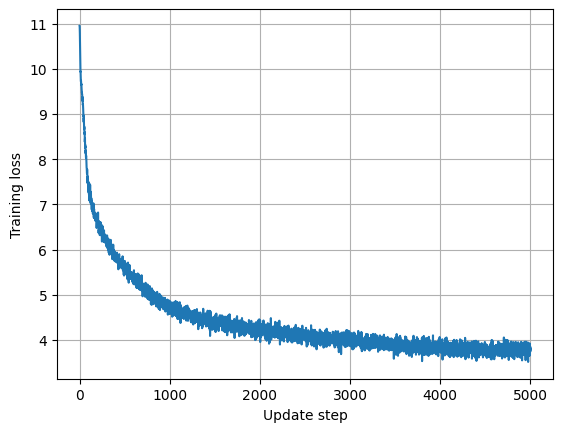

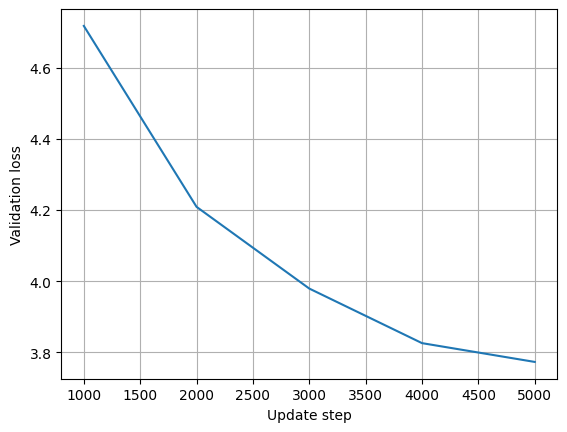

In [18]:
import matplotlib.pyplot as plt

losses_ = [l for (l,s) in losses]
plt.plot(losses_)
plt.grid()
plt.xlabel("Update step")
plt.ylabel("Training loss")
plt.show()

eval_losses_ = [l for (l,s) in eval_losses]
eval_steps = [s for (l,s) in eval_losses]
plt.plot(eval_steps, eval_losses_)
plt.grid()
plt.xlabel("Update step")
plt.ylabel("Validation loss")
plt.show()